In [1]:
import pandas as pd
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [2]:
cn7 = pd.read_csv("./data/labeled_data.csv")
cn7 = cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "PART_FACT_SERIAL",
                        "EQUIP_NAME", "EQUIP_CD", "Reason", "Clamp_Open_Position",
                        "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
                        "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
                        "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7","Switch_Over_Position"])
cn7 = cn7[(cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G RH") | (cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G LH")]
cn7 = cn7.drop(columns=["PART_NAME"])
cn7 = cn7.replace("Y", 1).replace("N", 0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18704\3887624601.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cn7 = cn7.replace("Y", 1).replace("N", 0)


In [3]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [4]:
cn7_pass = cn7[cn7["PassOrFail"] == 1]
cn7_fail = cn7[cn7["PassOrFail"] == 0]
cn7_pass_removed = cn7_pass.copy()
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Injection_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Plasticizing_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Cycle_Time')
cn7_removed = pd.concat([cn7_pass_removed, cn7_fail], ignore_index=True)


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [6]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999574,0.996032,0.996205,0.996205,0.996205,0.003543,10,6,4,1971,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
1,ExtraTreesClassifier,0.999574,0.999008,1.000000,0.998102,0.999050,0.000567,10,6,7,1968,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999574,0.996032,0.996205,0.996205,0.996205,0.003543,10,6,5,1970,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999574,0.996032,0.998095,0.994307,0.996198,0.003543,10,6,8,1967,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999574,0.997024,0.998099,0.996205,0.997151,0.002551,10,6,6,1969,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


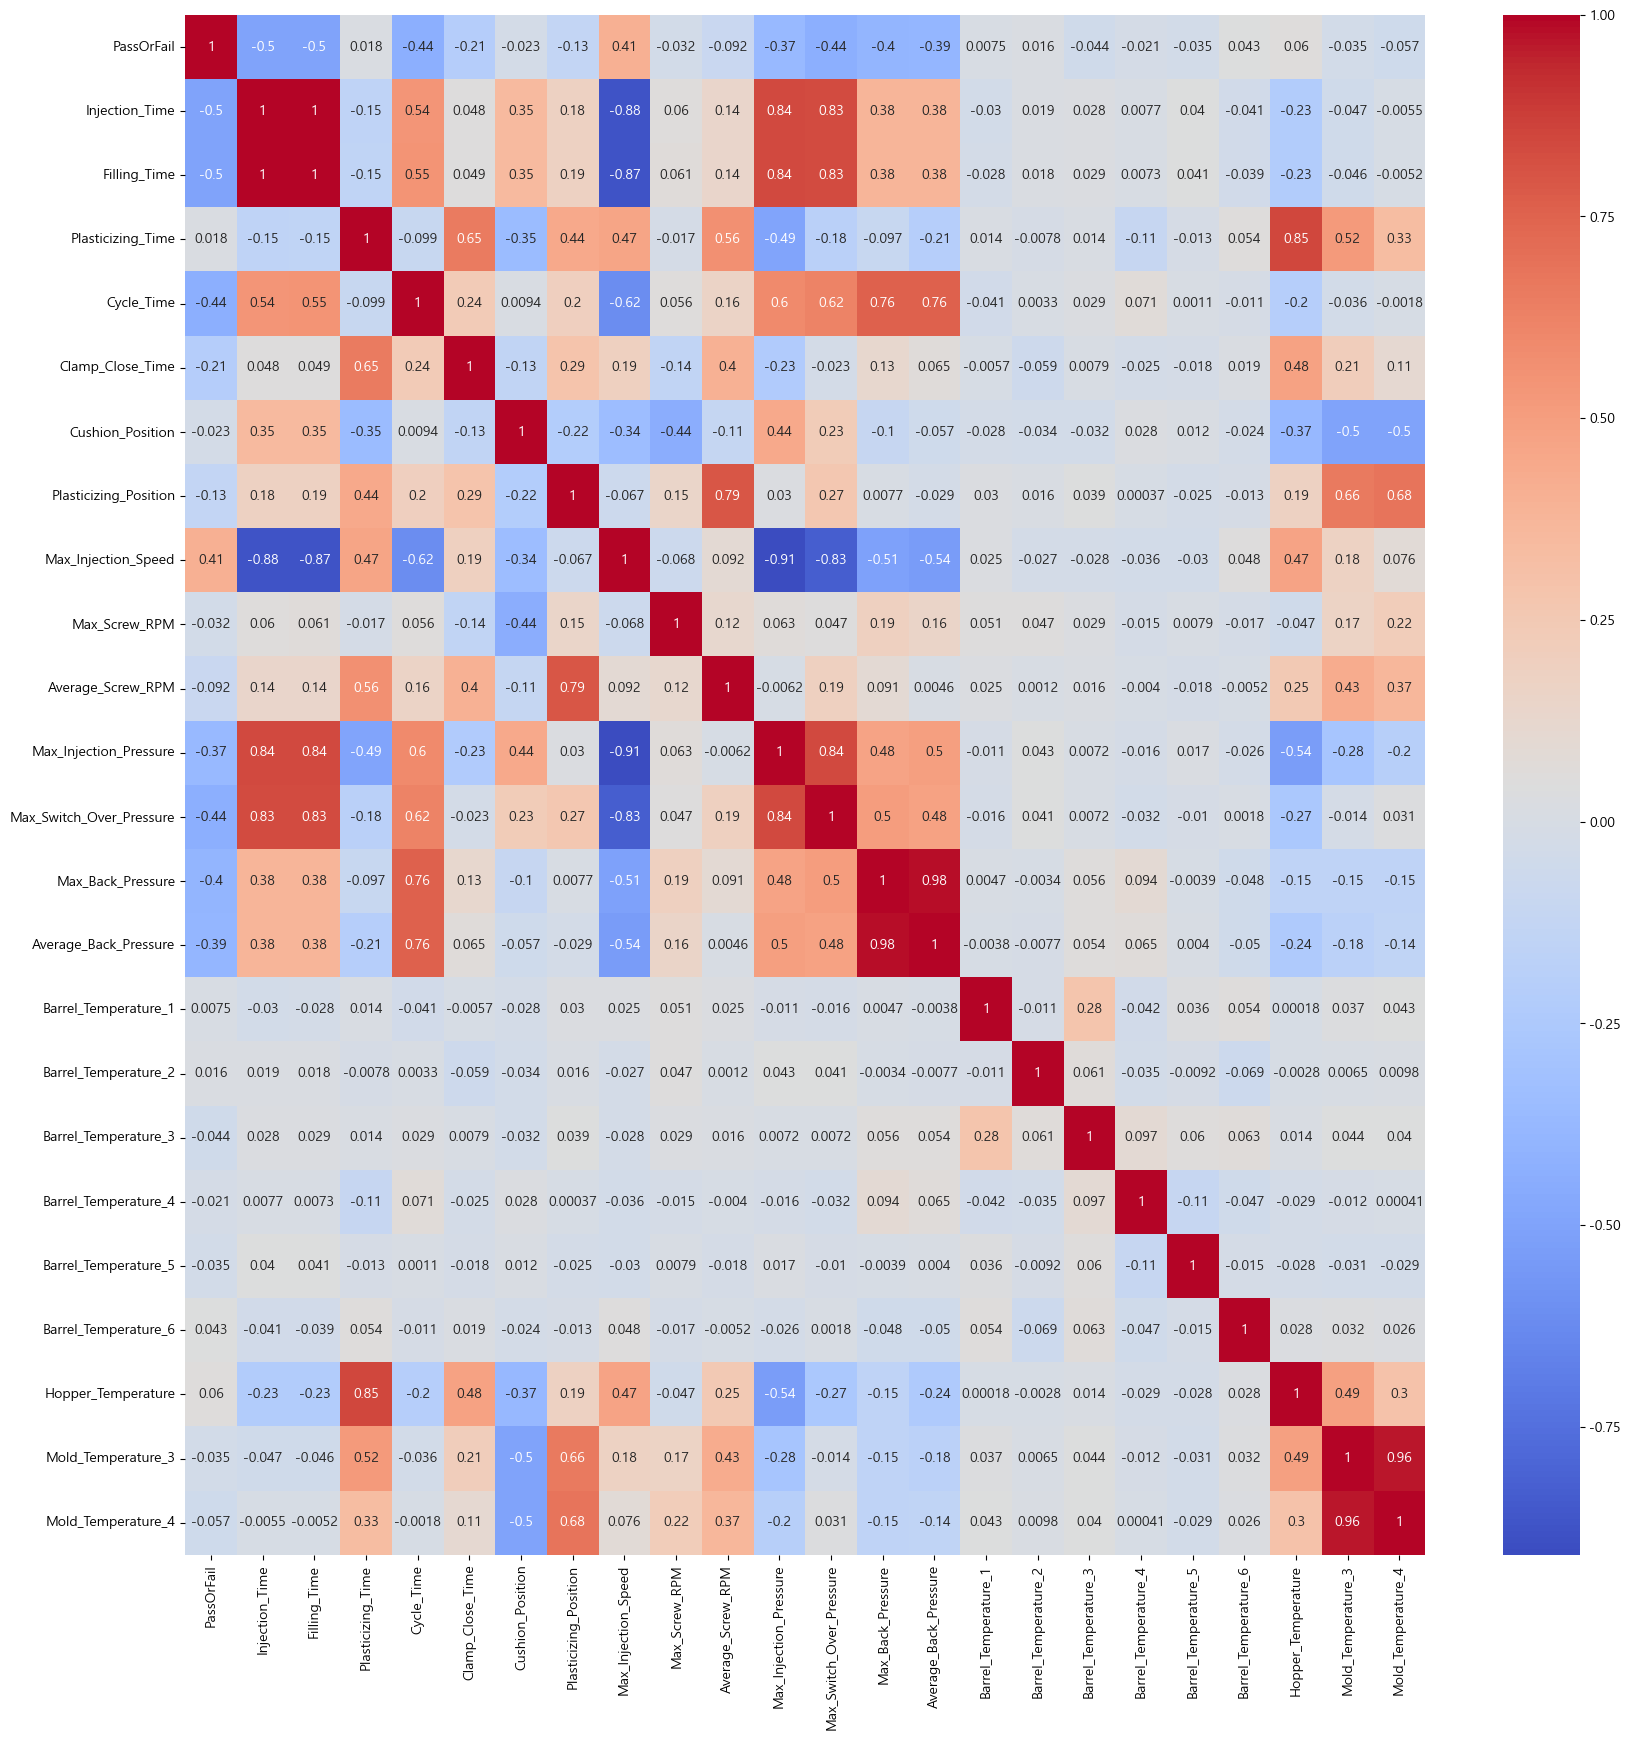

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed.corr(), annot=True, cmap='coolwarm')
plt.show()


In [8]:
cn7_test = cn7_removed.drop(columns=['Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'])

In [9]:
cn7_removed.columns

Index(['PassOrFail', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

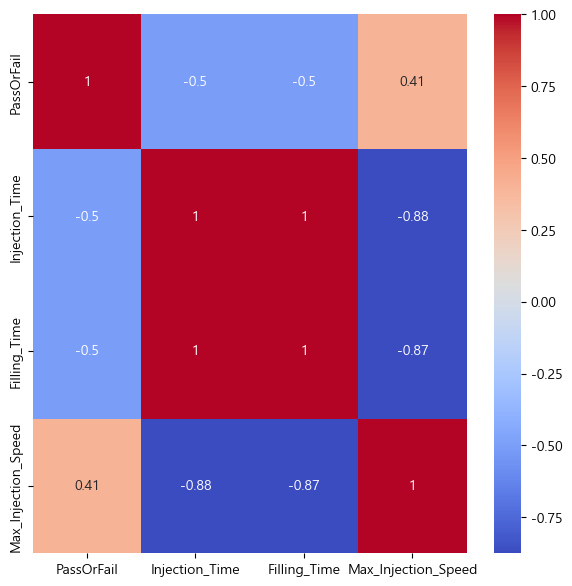

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.heatmap(cn7_test.corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
cn7_removed = cn7_removed.drop(columns = ["Filling_Time", "Average_Back_Pressure", "Mold_Temperature_3", "Max_Injection_Pressure",
                                          "Plasticizing_Time", "Max_Injection_Speed"])

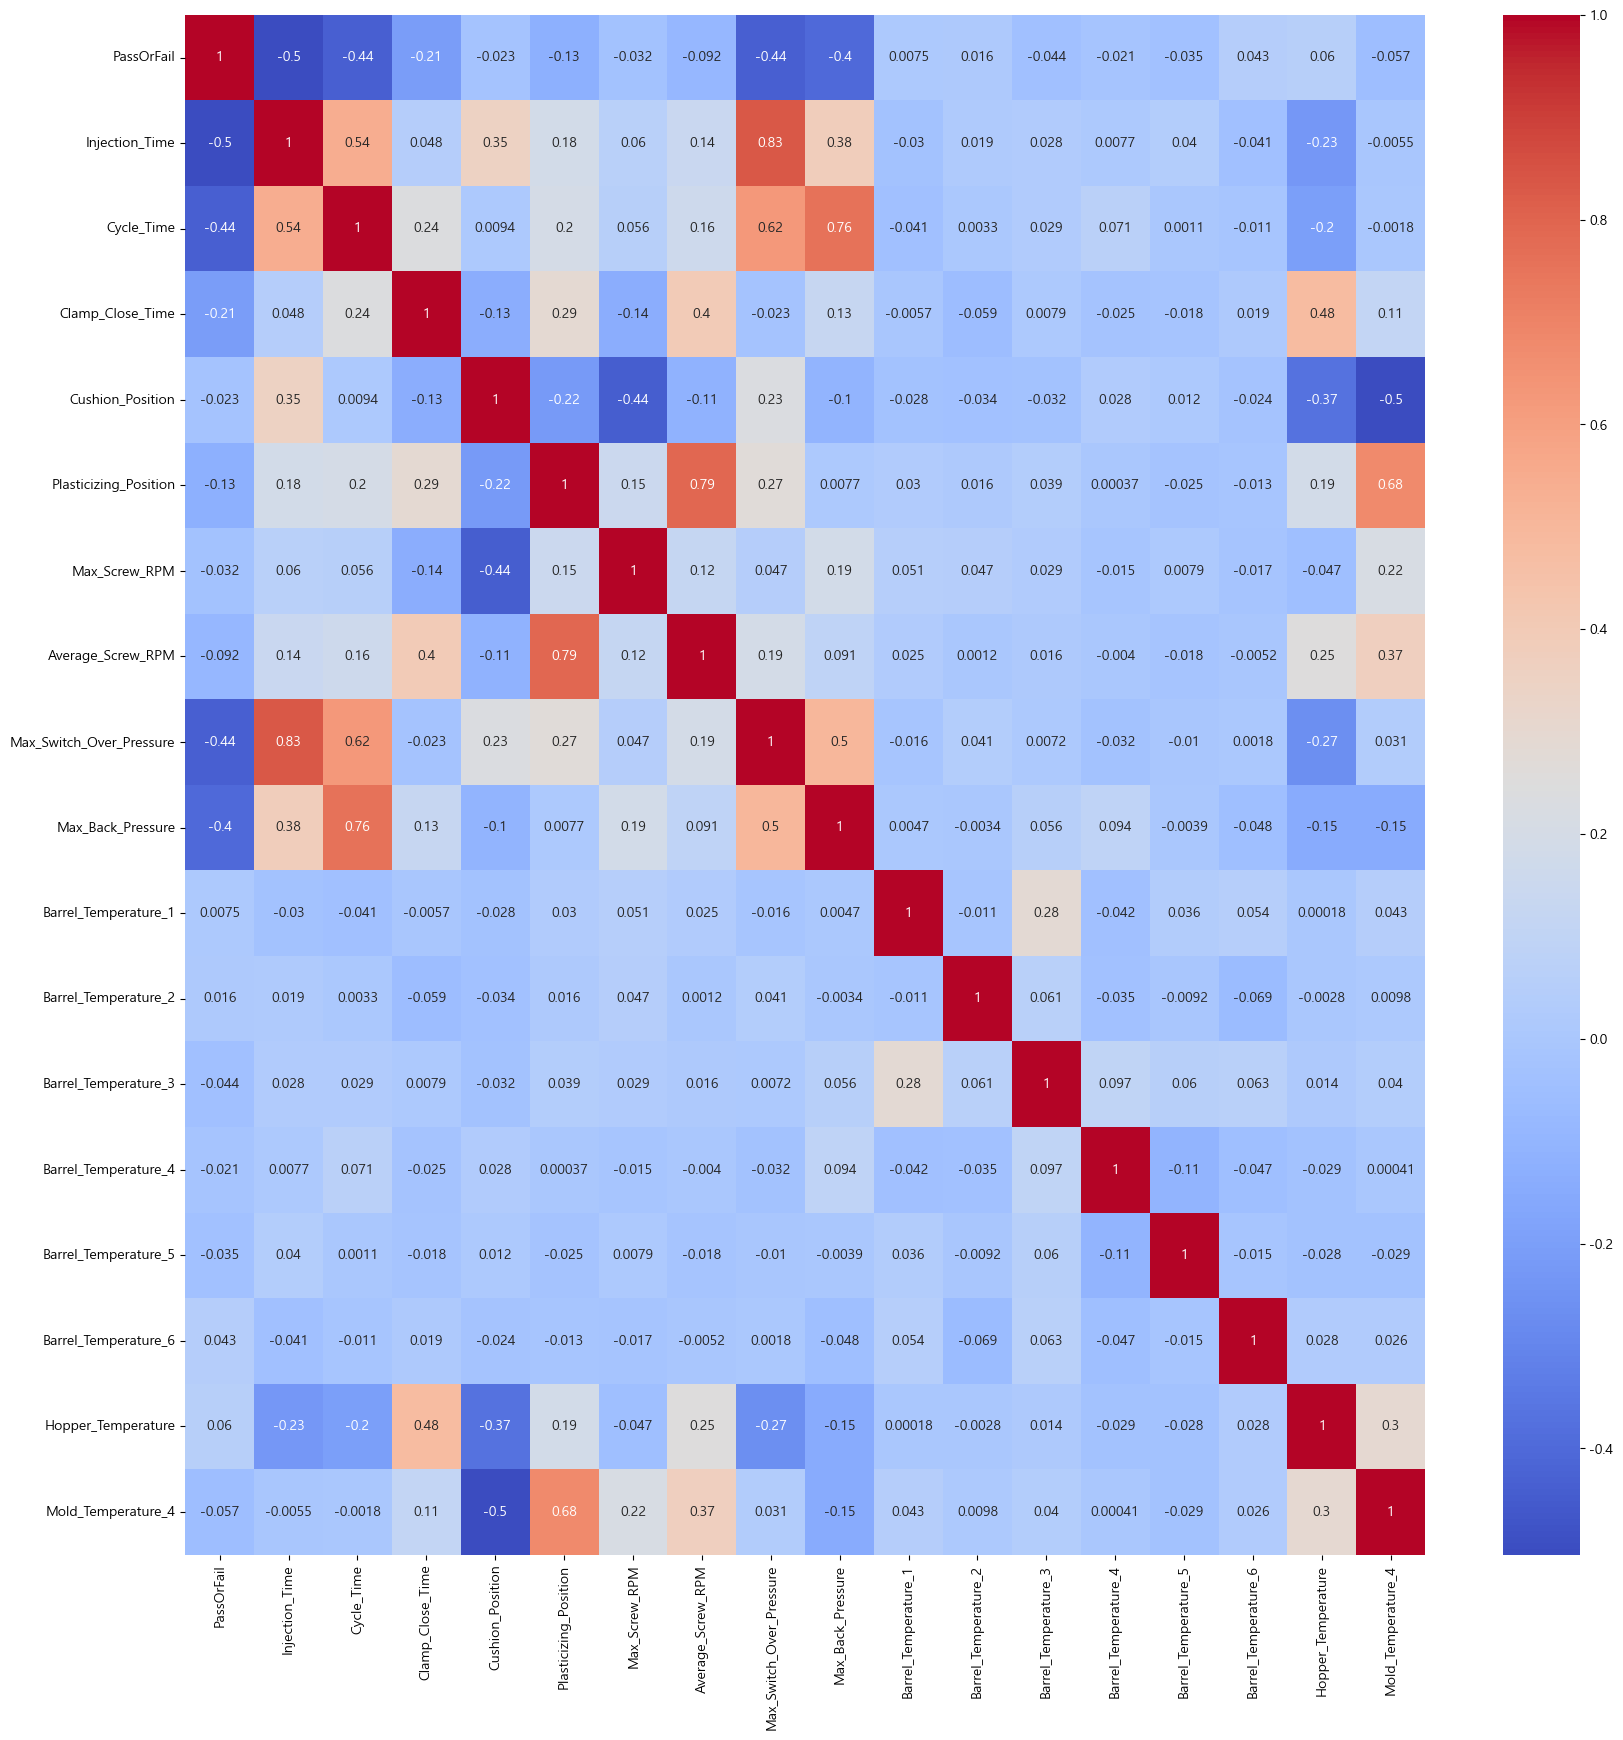

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed.corr(), annot=True, cmap='coolwarm')
plt.show()

In [13]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999574,0.997024,0.996212,0.998102,0.997156,0.002551,11,5,4,1971,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999574,0.999008,1.000000,0.998102,0.999050,0.000567,10,6,6,1969,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999574,0.995040,0.994318,0.996205,0.995261,0.004535,11,5,6,1969,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999574,0.994048,0.992439,0.996205,0.994318,0.005527,11,5,7,1968,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999574,0.996032,0.996205,0.996205,0.996205,0.003543,11,5,5,1970,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


In [14]:
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

from scipy.stats import spearmanr, pearsonr

X_columns_nm = cn7_removed.columns

for col in X_columns_nm:
    s, p = spearmanr(cn7_removed[col], y)
    msg = f"""
        독립변수({col})와 종속변수(PassOrFail)의 상관관계 계수는 {s:.7f}이고, p-value의 값은 {p:.7f} 입니다.
    """
    print(msg)


        독립변수(PassOrFail)와 종속변수(PassOrFail)의 상관관계 계수는 1.0000000이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Injection_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0581749이고, p-value의 값은 0.0000021 입니다.
    

        독립변수(Cycle_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0374413이고, p-value의 값은 0.0022844 입니다.
    

        독립변수(Clamp_Close_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0890845이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Cushion_Position)와 종속변수(PassOrFail)의 상관관계 계수는 0.0602227이고, p-value의 값은 0.0000009 입니다.
    

        독립변수(Plasticizing_Position)와 종속변수(PassOrFail)의 상관관계 계수는 -0.1070542이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Screw_RPM)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0222816이고, p-value의 값은 0.0695271 입니다.
    

        독립변수(Average_Screw_RPM)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0849173이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Switch_Over_Pressure)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0844067이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Back_Pressure)와 종속변수(PassOrFail)의

In [16]:
cn7_removed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6636 non-null   int64  
 1   Injection_Time            6636 non-null   float64
 2   Cycle_Time                6636 non-null   float64
 3   Clamp_Close_Time          6636 non-null   float64
 4   Cushion_Position          6636 non-null   float64
 5   Plasticizing_Position     6636 non-null   float64
 6   Max_Screw_RPM             6636 non-null   float64
 7   Average_Screw_RPM         6636 non-null   float64
 8   Max_Switch_Over_Pressure  6636 non-null   float64
 9   Max_Back_Pressure         6636 non-null   float64
 10  Barrel_Temperature_1      6636 non-null   float64
 11  Barrel_Temperature_2      6636 non-null   float64
 12  Barrel_Temperature_3      6636 non-null   float64
 13  Barrel_Temperature_4      6636 non-null   float64
 14  Barrel_T

In [17]:
cn7_removed_temp = cn7_removed.drop(columns = ["Max_Screw_RPM", "Max_Back_Pressure", "Barrel_Temperature_1", 
                                          "Barrel_Temperature_2","Barrel_Temperature_3", "Barrel_Temperature_4",
                                          "Barrel_Temperature_5", "Barrel_Temperature_6", "Mold_Temperature_4"])

In [18]:
cn7_removed_temp

,PassOrFail,Injection_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Average_Screw_RPM,Max_Switch_Over_Pressure,Hopper_Temperature
0,1,9.59,59.520000,7.13,653.409973,68.849998,292.500000,136.800003,66.300003
1,1,9.60,59.580002,7.13,653.409973,68.839996,292.500000,136.899994,67.199997
2,1,9.60,59.580002,7.13,653.409973,68.839996,292.500000,136.899994,67.199997
3,1,9.59,59.560001,7.13,653.419983,68.839996,292.500000,136.800003,66.900002
4,1,9.59,59.560001,7.13,653.419983,68.839996,292.500000,136.800003,66.900002
...,...,...,...,...,...,...,...,...,...
6631,0,9.98,60.459999,7.12,653.409973,68.610001,292.500000,139.000000,65.000000
6632,0,9.98,60.459999,7.12,653.409973,68.610001,292.500000,139.000000,65.000000
6633,0,9.70,58.959999,7.12,653.450012,68.589996,292.299988,137.399994,64.500000
6634,0,9.70,58.959999,7.12,653.450012,68.589996,292.299988,137.399994,64.500000


In [19]:
cn7_removed_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6636 non-null   int64  
 1   Injection_Time            6636 non-null   float64
 2   Cycle_Time                6636 non-null   float64
 3   Clamp_Close_Time          6636 non-null   float64
 4   Cushion_Position          6636 non-null   float64
 5   Plasticizing_Position     6636 non-null   float64
 6   Average_Screw_RPM         6636 non-null   float64
 7   Max_Switch_Over_Pressure  6636 non-null   float64
 8   Hopper_Temperature        6636 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 466.7 KB


In [20]:
from sklearn.model_selection import train_test_split
X = cn7_removed_temp.drop(columns=["PassOrFail"])
y = cn7_removed_temp["PassOrFail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [21]:

# 모델 학습 후 회귀계수 획득 (이미 model.fit()을 수행했다고 가정)
coefficients = model.feature_importances_

# 독립변수와 회귀계수로 DataFrame 생성
df_coeff = pd.DataFrame({'독립변수': X.columns, '회귀계수': coefficients, "제곱" : coefficients * coefficients})

# 회귀계수를 기준으로 내림차순 정렬 (가장 큰 영향력부터 보고자 할 때)
df_coeff_sorted = df_coeff.sort_values(by='제곱', ascending=False)

df_coeff_sorted

,독립변수,회귀계수,제곱
0,Injection_Time,0.311726,0.097173
6,Max_Switch_Over_Pressure,0.196759,0.038714
3,Cushion_Position,0.188759,0.035630
1,Cycle_Time,0.109008,0.011883
7,Hopper_Temperature,0.087953,0.007736
2,Clamp_Close_Time,0.048263,0.002329
4,Plasticizing_Position,0.044113,0.001946
5,Average_Screw_RPM,0.013418,0.000180


In [22]:

# 독립변수 종속변수 분리 
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train


# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)


RandomForestClassifier()

In [23]:
X_train.columns

Index(['Injection_Time', 'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Average_Screw_RPM',
       'Max_Switch_Over_Pressure', 'Hopper_Temperature'],
      dtype='object')

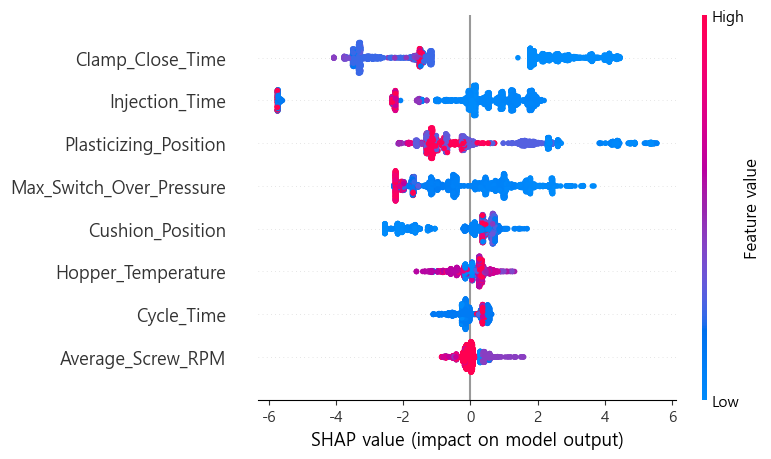

In [27]:

import shap
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled,  check_additivity=False)

# X_train_scaled를 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_train_scaled_df)


In [30]:

import numpy as np
import pandas as pd

# SHAP 값은 explainer 호출 후 shap_values 객체에 저장됩니다.
# 각 피처의 평균 절대 기여도를 계산합니다.
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
# DataFrame으로 정리하여 피처명과 함께 보기 좋게 구성합니다.
shap_importance_df = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'Mean_Absolute_SHAP': mean_abs_shap
})

# 평균 절대 SHAP 값 기준 내림차순 정렬
shap_importance_df.sort_values('Mean_Absolute_SHAP', ascending=False, inplace=True)
print(shap_importance_df)

                    Feature  Mean_Absolute_SHAP
2          Clamp_Close_Time            2.643224
0            Injection_Time            1.394353
4     Plasticizing_Position            1.385389
6  Max_Switch_Over_Pressure            1.233530
3          Cushion_Position            0.849697
7        Hopper_Temperature            0.314791
1                Cycle_Time            0.305454
5         Average_Screw_RPM            0.224799


In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.998723,0.996032,0.992467,1.000000,0.996219,0.002692,11,5,2,1973,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999574,0.996032,1.000000,0.992410,0.996190,0.003543,11,5,8,1967,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999574,0.994048,0.992439,0.996205,0.994318,0.005527,11,5,6,1969,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.998298,0.998016,1.000000,0.996205,0.998099,0.000282,8,8,8,1967,"{'max_depth': 50, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999574,0.998016,0.998102,0.998102,0.998102,0.001559,11,5,4,1971,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


In [32]:
cn7_removed_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassOrFail                6636 non-null   int64  
 1   Injection_Time            6636 non-null   float64
 2   Cycle_Time                6636 non-null   float64
 3   Clamp_Close_Time          6636 non-null   float64
 4   Cushion_Position          6636 non-null   float64
 5   Plasticizing_Position     6636 non-null   float64
 6   Average_Screw_RPM         6636 non-null   float64
 7   Max_Switch_Over_Pressure  6636 non-null   float64
 8   Hopper_Temperature        6636 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 466.7 KB


In [33]:
cn7_removed_temp = cn7_removed_temp.drop(columns = ["Cushion_Position"])

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999574,0.997024,0.998099,0.996205,0.997151,0.002551,11,5,5,1970,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999574,0.997024,1.000000,0.994307,0.997146,0.002551,11,5,7,1968,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999574,0.993056,0.992424,0.994307,0.993365,0.006519,11,5,7,1968,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.998298,0.999008,1.000000,0.998102,0.999050,-0.000710,8,8,7,1968,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999149,0.998016,0.998102,0.998102,0.998102,0.001133,11,5,7,1968,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


In [35]:
cn7_removed_temp1 = cn7_removed_temp.drop(columns = ["Injection_Time"])

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp1["PassOrFail"]
X = cn7_removed_temp1.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999574,0.995040,0.996198,0.994307,0.995252,0.004535,11,5,6,1969,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999574,0.996032,1.000000,0.992410,0.996190,0.003543,11,5,10,1965,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.998723,0.994048,0.992439,0.996205,0.994318,0.004676,7,9,21,1954,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999574,0.997024,1.000000,0.994307,0.997146,0.002551,12,4,8,1967,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999574,0.997024,0.998099,0.996205,0.997151,0.002551,11,5,7,1968,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [37]:
cn7_removed_temp2 = cn7_removed_temp.drop(columns = ["Max_Switch_Over_Pressure"])

In [38]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp2["PassOrFail"]
X = cn7_removed_temp2.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999149,0.995040,0.992453,0.998102,0.995270,0.004109,11,5,4,1971,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.997447,0.995040,1.000000,0.990512,0.995234,0.002407,12,4,15,1960,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999149,0.999008,0.998106,1.000000,0.999052,0.000141,11,5,4,1971,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999149,0.997024,0.994340,1.000000,0.997162,0.002125,11,5,3,1972,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999149,0.998016,0.996219,1.000000,0.998106,0.001133,11,5,3,1972,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


In [39]:
cn7_removed_temp3 = cn7_removed_temp1.drop(columns = ["Cycle_Time"])

In [40]:
cn7_removed_temp3["Average_Screw_RPM"].value_counts()

Average_Screw_RPM
29.200001     4182
292.500000    1427
292.399994     787
292.600006     186
292.299988      52
292.700012       2
Name: count, dtype: int64

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp3["PassOrFail"]
X = cn7_removed_temp3.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.996596,0.991071,0.996169,0.986717,0.991420,0.005524,8,8,10,1965,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.998723,0.994048,1.000000,0.988615,0.994275,0.004676,10,6,9,1966,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999149,0.989087,0.986792,0.992410,0.989593,0.010062,8,8,6,1969,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999149,0.990079,0.994264,0.986717,0.990476,0.009070,10,6,11,1964,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.997872,0.993056,1.000000,0.986717,0.993314,0.004817,11,5,15,1960,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y = cn7_removed_temp3["PassOrFail"]
X = cn7_removed_temp3.drop(columns=["PassOrFail"])

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. 전체 모델 학습 및 성능 측정
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Baseline Accuracy: {baseline_accuracy}")

# 2. 각 변수 제거 후 성능 측정
importances = []
for col in X.columns:
    # 해당 변수를 제거한 데이터셋 생성
    X_train_dropped = X_train.drop(columns=[col])
    X_test_dropped = X_test.drop(columns=[col])
    
    # 모델 재학습 및 성능 측정
    model.fit(X_train_dropped, y_train)
    dropped_accuracy = accuracy_score(y_test, model.predict(X_test_dropped))
    
    # 변수 중요도 계산 (성능 하락량)
    importance = baseline_accuracy - dropped_accuracy
    importances.append((col, importance))

# 3. 결과 정렬 및 출력
importances.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importances:
    print(f"Feature: {feature}, Importance: {importance}")

Baseline Accuracy: 0.9939728779507785
Feature: Max_Switch_Over_Pressure, Importance: 0.0
Feature: Average_Screw_RPM, Importance: -0.0005022601707684871
Feature: Clamp_Close_Time, Importance: -0.0010045203415369741
Feature: Plasticizing_Position, Importance: -0.0015067805123053502
Feature: Hopper_Temperature, Importance: -0.002009040683073837
